# Vision Transformer Denoiser for Colon Histopathological Images

This notebook implements a Vision Transformer based denoiser model using TensorFlow. In this example, we load images from both classes of the [Lung and Colon Cancer Histopathological Images](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images) dataset (i.e. `colon_aca` and `colon_n`). Instead of training on one class and testing on the other, we combine both classes into a single dataset, then randomly split it (80% training, 20% testing). This approach ensures that the model learns from the full data distribution and produces more robust denoising results.

The notebook includes the following steps:
- **Imports and Setup:** Import necessary libraries and set hyperparameters.
- **Model Definition:** Build a Vision Transformer denoiser with a combined loss (MSE + SSIM loss).
- **Data Loading and Splitting:** Load images from both classes, create noisy versions, and split the data.
- **Training:** Train the model on the noisy images with clean images as targets.
- **Evaluation:** Compute PSNR and SSIM metrics on the test set.
- **Visualization:** Visualize a sample clean, noisy, and denoised image.

In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
from IPython.display import clear_output
from tensorflow.keras.models import load_model
import threading
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint


print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.17.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Hyperparameters and Combined Loss Function

We set our hyperparameters and define a custom combined loss function that is the sum of the Mean Squared Error (MSE) loss and a weighted SSIM loss (which encourages structural similarity).

In [3]:
# --- Hyperparameters ---
IMG_SIZE = 64
PATCH_SIZE = 8              # Smaller patch size to capture finer details
EMBED_DIM = 128
NUM_HEADS = 8
MLP_DIM = 256
DEPTH = 12                  # Increased depth for more capacity
BATCH_SIZE = 32
EPOCHS = 50
NOISE_STDDEV = 0.05
LEARNING_RATE = 1e-4

# --- Combined Loss Function ---
def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return mse_loss + 0.1 * ssim_loss

print("Hyperparameters and loss function set.")

Hyperparameters and loss function set.


## Building Blocks: Transformer Block and Patch Embedding

We now define our custom transformer block (with multi-head self-attention and an MLP) and the patch embedding layer which divides the image into patches and adds positional embeddings.

In [4]:
# Transformer block with residual connections
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.mlp = keras.Sequential([
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout = layers.Dropout(dropout)
    
    def call(self, x, training=False):
        attn_output = self.att(x, x, training=training)
        x = self.norm1(x + self.dropout(attn_output, training=training))
        mlp_output = self.mlp(x)
        x = self.norm2(x + self.dropout(mlp_output, training=training))
        return x

# Patch embedding layer
class PatchEmbedding(layers.Layer):
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')
        self.flatten = layers.Reshape((self.num_patches, embed_dim))
        self.pos_embed = self.add_weight(name="pos_embed",
                                         shape=(1, self.num_patches, embed_dim),
                                         initializer='random_normal',
                                         trainable=True)
    
    def call(self, x):
        x = self.proj(x)
        x = self.flatten(x)
        return x + self.pos_embed

print("TransformerBlock and PatchEmbedding defined.")

TransformerBlock and PatchEmbedding defined.


## Vision Transformer Denoiser Model

We build our Vision Transformer denoiser model. It begins with an initial convolution to extract local features (used as a skip connection), creates patch embeddings, processes them through several transformer blocks, and then reconstructs the denoised image using a transposed convolution along with a skip connection.

In [5]:
def build_vit_denoiser(img_size, patch_size, embed_dim, num_heads, mlp_dim, depth):
    inputs = keras.Input(shape=(img_size, img_size, 3))
    
    # Initial convolution for local features (skip connection)
    conv_features = layers.Conv2D(embed_dim, kernel_size=3, padding='same', activation='relu')(inputs)
    
    # Create patch embeddings from conv features
    x = PatchEmbedding(img_size, patch_size, embed_dim)(conv_features)
    
    # Pass through transformer blocks
    for _ in range(depth):
        x = TransformerBlock(embed_dim, num_heads, mlp_dim)(x)
    
    # Reshape back to spatial grid
    num_patches_side = img_size // patch_size
    x = layers.Reshape((num_patches_side, num_patches_side, embed_dim))(x)
    
    # Upsample using transposed convolution
    x = layers.Conv2DTranspose(embed_dim, kernel_size=patch_size, strides=patch_size, 
                               padding='same', activation='relu')(x)
    
    # Add skip connection
    x = layers.Add()([x, conv_features])
    
    # Final reconstruction layer
    outputs = layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name="Robust_ViT_Denoiser")
    return model

# Build and compile the model
model = build_vit_denoiser(IMG_SIZE, PATCH_SIZE, EMBED_DIM, NUM_HEADS, MLP_DIM, DEPTH)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=combined_loss, metrics=['mae'])
model.summary()

Model: "Robust_ViT_Denoiser"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 128)    │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_embedding           │ (None, 64, 128)        │      1,056,896 │ conv2d[0][0]           │
│ (PatchEmbedding)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block         │ (None, 64, 128)        │        593,920 │ patch_embedding[0][0]  │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_1       │ (None, 64, 128)        │        593,920 │ transformer_block[0][… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_2       │ (None, 64, 128)        │        593,920 │ transformer_block_1[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_3       │ (None, 64, 128)        │        593,920 │ transformer_block_2[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_4       │ (None, 64, 128)        │        593,920 │ transformer_block_3[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_5       │ (None, 64, 128)        │        593,920 │ transformer_block_4[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_6       │ (None, 64, 128)        │        593,920 │ transformer_block_5[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_7       │ (None, 64, 128)        │        593,920 │ transformer_block_6[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_8       │ (None, 64, 128)        │        593,920 │ transformer_block_7[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_9       │ (None, 64, 128)        │        593,920 │ transformer_block_8[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_10      │ (None, 64, 128)        │        593,920 │ transformer_block_9[0… │
│ (TransformerBlock)   

 Total params: 9,239,683 (35.25 MB)

 Trainable params: 9,239,683 (35.25 MB)

 Non-trainable params: 0 (0.00 B)

## Data Loading and Splitting

We load images from both `colon_aca` (adenocarcinoma) and `colon_n` (normal) folders, combine them into one dataset, create noisy versions, and then randomly split the data into training (80%) and testing (20%) sets.

In [6]:
def load_dataset(directory, img_size):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        try:
            # Read image using OpenCV
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError("Image could not be read (None).")
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize image
            img = cv2.resize(img, (img_size, img_size))
            # Normalize image to [0, 1]
            img = img.astype(np.float32) / 255.0
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
        images.append(img)
    return np.array(images)

# --- Dataset Paths ---
path_colon_aca = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca'  # Adenocarcinoma images
path_colon_n   = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n'    # Normal images

# Load images from both folders using OpenCV
images_aca = load_dataset(path_colon_aca, IMG_SIZE)
images_n   = load_dataset(path_colon_n, IMG_SIZE)

# Combine datasets
all_images = np.concatenate([images_aca, images_n], axis=0)
print("Total images loaded:", all_images.shape[0])

# Create noisy versions of the entire dataset
all_images_noisy = np.clip(all_images + np.random.normal(0, NOISE_STDDEV, all_images.shape), 0.0, 1.0)

# Split into training and testing sets (80% train, 20% test)
x_train_clean, x_test_clean, x_train_noisy, x_test_noisy = train_test_split(
    all_images, all_images_noisy, test_size=0.2, random_state=42)
print("Training samples:", x_train_clean.shape[0])
print("Testing samples:", x_test_clean.shape[0])

Total images loaded: 10000
Training samples: 8000
Testing samples: 2000


## Data Visualization

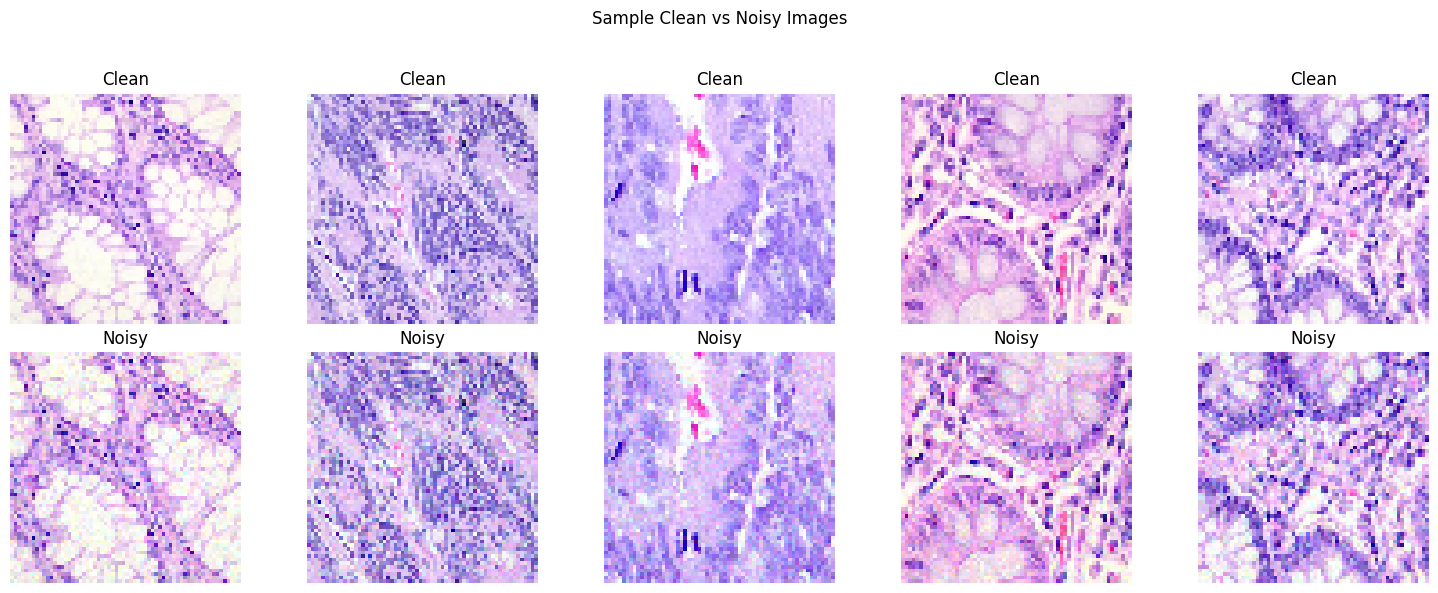

In [7]:
def visualize_samples(x_clean, x_noisy, n_samples=5):
    """
    Display a grid of sample images, showing the clean image on the top row
    and the corresponding noisy image on the bottom row.

    Parameters:
        x_clean (numpy.ndarray): Array of clean images.
        x_noisy (numpy.ndarray): Array of noisy images.
        n_samples (int): Number of samples to display.
    """
    plt.figure(figsize=(15, 6))
    for i in range(n_samples):
        # Plot clean image
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(x_clean[i])
        plt.title("Clean")
        plt.axis("off")
        
        # Plot corresponding noisy image
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(x_noisy[i])
        plt.title("Noisy")
        plt.axis("off")
    
    plt.suptitle("Sample Clean vs Noisy Images")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the function to visualize 5 sample images
visualize_samples(x_train_clean, x_train_noisy, n_samples=5)

## Live Plot Callback for Training Visualization

In this project, we created two custom callbacks to visualize training progress in real time.

### 1. LivePlotCallbackBatch

**Description:**  
This callback updates the visualization after every batch. It shows a few sample images (noisy input, denoised output, and the clean target) after each batch. Although this gives very granular feedback, updating after every batch may slow down training since plotting can be a blocking operation.


In [8]:
class LivePlotCallbackBatch(tf.keras.callbacks.Callback):
    def __init__(self, x_sample, y_sample):
        """
        x_sample: A small set of noisy sample images to visualize.
        y_sample: The corresponding clean target images.
        """
        super().__init__()
        self.x_sample = x_sample
        self.y_sample = y_sample

    def on_batch_end(self, batch, logs=None):
        # Predict the denoised images for the sample batch
        pred = self.model.predict(self.x_sample, verbose=0)
        clear_output(wait=True)
        num_samples = len(self.x_sample)
        plt.figure(figsize=(15, 5))
        for i in range(num_samples):
            # Noisy image
            plt.subplot(3, num_samples, i + 1)
            plt.imshow(self.x_sample[i])
            plt.title("Noisy")
            plt.axis("off")
            # Denoised image
            plt.subplot(3, num_samples, i + 1 + num_samples)
            plt.imshow(pred[i])
            plt.title("Denoised")
            plt.axis("off")
            # Clean target image
            plt.subplot(3, num_samples, i + 1 + 2*num_samples)
            plt.imshow(self.y_sample[i])
            plt.title("Clean")
            plt.axis("off")
        plt.suptitle(f"Batch {batch + 1}")
        plt.show()

### 2. LivePlotCallbackAsync
   
**Description:**  
This callback updates the visualization asynchronously every interval batches (e.g., every 10 batches). It uses Python's threading to perform the plotting in a separate thread, thereby reducing the blocking overhead and ensuring that the training loop isn't significantly delayed. This approach strikes a balance between live feedback and training efficiency.

In [9]:
def async_plot(x_sample, y_sample, pred, batch):
    """Function to update the plot asynchronously."""
    clear_output(wait=True)
    num_samples = len(x_sample)
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Plot noisy image
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(x_sample[i])
        plt.title("Noisy")
        plt.axis("off")
        # Plot denoised image
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(pred[i])
        plt.title("Denoised")
        plt.axis("off")
        # Plot clean image
        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(y_sample[i])
        plt.title("Clean")
        plt.axis("off")
    plt.suptitle(f"Batch {batch + 1}")
    plt.show()

class LivePlotCallbackAsync(tf.keras.callbacks.Callback):
    def __init__(self, x_sample, y_sample, interval=10):
        """
        x_sample: a small set of sample noisy images to visualize.
        y_sample: the corresponding clean images.
        interval: update the visualization every `interval` batches.
        """
        super().__init__()
        self.x_sample = x_sample
        self.y_sample = y_sample
        self.interval = interval

    def on_batch_end(self, batch, logs=None):
        # Update only every 'interval' batches
        if (batch + 1) % self.interval == 0:
            # Run prediction on sample images
            pred = self.model.predict(self.x_sample, verbose=0)
            # Start a new thread for plotting so that the training loop isn't blocked
            thread = threading.Thread(target=async_plot, args=(self.x_sample, self.y_sample, pred, batch))
            thread.start()


### 3. LivePlotCallback

**Description:**  
After each epoch (or every specified interval), the callback will display the current state of the denoised images alongside the noisy input and clean target. This gives you a real-time visual feedback loop during training.

In [10]:
class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_sample, y_sample, interval=1):
        """
        x_sample: sample noisy images (inputs)
        y_sample: corresponding clean images (targets)
        interval: update every 'interval' epochs.
        """
        super().__init__()
        self.x_sample = x_sample
        self.y_sample = y_sample
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        # Update only every 'interval' epochs
        if (epoch + 1) % self.interval == 0:
            pred = self.model.predict(self.x_sample)
            clear_output(wait=True)
            num_samples = len(self.x_sample)
            plt.figure(figsize=(15, 5))
            for i in range(num_samples):
                # Noisy input image
                plt.subplot(3, num_samples, i + 1)
                plt.imshow(self.x_sample[i])
                plt.title("Noisy")
                plt.axis("off")
                # Denoised output
                plt.subplot(3, num_samples, i + 1 + num_samples)
                plt.imshow(pred[i])
                plt.title("Denoised")
                plt.axis("off")
                # Ground-truth clean image
                plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
                plt.imshow(self.y_sample[i])
                plt.title("Clean")
                plt.axis("off")
            plt.suptitle(f"Epoch {epoch + 1}")
            plt.show()


In [11]:
# Choose 3 random samples from the test set for visualization
sample_indices = np.random.choice(x_test_noisy.shape[0], size=3, replace=False)
x_sample = x_test_noisy[sample_indices]
y_sample = x_test_clean[sample_indices]

# Create a callback to visualize the denoising results during training
#NOTE: These callbacks are CPU intensive. Use them when you have to visualize the training process for few epochs.

#CPU intensive, update frequency is at every step.
live_plot_batch = LivePlotCallbackBatch(x_sample, y_sample)
#Async plotting, plot after 10 steps/intervals
live_plot_async = LivePlotCallbackAsync(x_sample, y_sample, interval=10)
#plot after 1 epoch
live_plot = LivePlotCallback(x_sample, y_sample, interval=1)

## Training the Model

We train the model on the noisy images with the corresponding clean images as targets.

In [12]:
# Train the model with the checkpoint callback
history = model.fit(
    x_train_noisy, x_train_clean,
    validation_data=(x_test_noisy, x_test_clean),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,)


#Uncomment below given code if you want model visualizationa at every step

# history = model.fit(
#     x_train_noisy, x_train_clean,
#     validation_data=(x_test_noisy, x_test_clean),
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
# callbacks = [live_plot_batch])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 84ms/step - loss: 0.1195 - mae: 0.1540 - val_loss: 0.0513 - val_mae: 0.0802
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0410 - mae: 0.0735 - val_loss: 0.0214 - val_mae: 0.0554
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0199 - mae: 0.0532 - val_loss: 0.0146 - val_mae: 0.0443
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 0.0143 - mae: 0.0442 - val_loss: 0.0123 - val_mae: 0.0409
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 0.0123 - mae: 0.0396 - val_loss: 0.0115 - val_mae: 0.0368
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 0.0116 - mae: 0.0374 - val_loss: 0.0111 - val_mae: 0.0367
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 0.0112 - mae: 0.0363 - val_loss: 0.0109 - val_mae: 0.0362
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0110 - mae: 0.0356 - val_loss: 0.0106 - val_mae: 0.0354
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluation

After training, we predict denoised images on the test set and compute the PSNR and SSIM metrics. Higher PSNR (ideally above 30 dB) and SSIM values (close to 1) indicate better denoising quality.

In [13]:
predicted = model.predict(x_test_noisy)

psnr_values = []
ssim_values = []
for orig_img, denoised_img in zip(x_test_clean, predicted):
    
    psnr_val = compute_psnr(orig_img, denoised_img, data_range=1.0)
    ssim_val = compute_ssim(orig_img, denoised_img, data_range=1.0, channel_axis=-1)
    psnr_values.append(psnr_val)
    ssim_values.append(ssim_val)

avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step
Average PSNR: 28.87 dB
Average SSIM: 0.9338


## Visualization

We display a sample of a clean image, its noisy version, and the corresponding denoised output.

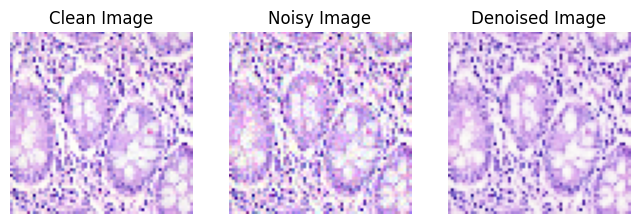

In [14]:
idx = 0  # Change the index to view different samples
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_test_clean[idx])
plt.title("Clean Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(x_test_noisy[idx])
plt.title("Noisy Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted[idx])
plt.title("Denoised Image")
plt.axis("off")

plt.show()

In [15]:
def display_images_grid(model, indices, x_test_clean, x_test_noisy):
    """
    Display multiple samples in a grid, where each sample is shown as a row of three images:
    the clean image, the noisy image, and the denoised image predicted by the model.
    
    Parameters:
        model: Trained denoising model.
        indices (list or array): List of indices for samples to display.
        x_test_clean (numpy.ndarray): Array of clean test images.
        x_test_noisy (numpy.ndarray): Array of noisy test images.
    """

    
    # Get predictions for the selected samples at once
    selected_noisy = x_test_noisy[indices]
    predicted_samples = model.predict(selected_noisy)
    
    n = len(indices)
    plt.figure(figsize=(8, 4 * n))  # Adjust height based on number of samples
    for i, idx in enumerate(indices):
        # Clean image
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(x_test_clean[idx])
        plt.title("Clean Image")
        plt.axis("off")
        
        # Noisy image
        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(x_test_noisy[idx])
        plt.title("Noisy Image")
        plt.axis("off")
        
        # Denoised image (prediction)
        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(predicted_samples[i])
        plt.title("Denoised Image")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


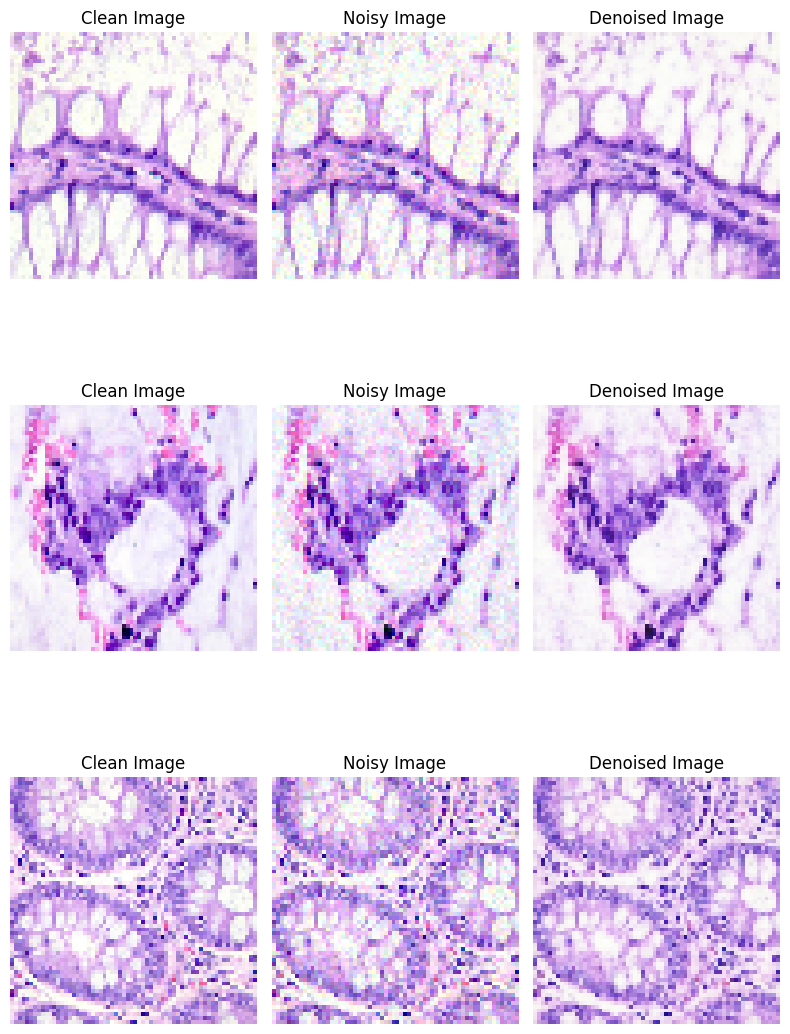

In [16]:
import random

# First number in the batch
max_value = x_test_noisy.shape[0]

# Generate three random numbers, each not exceeding the first number
random_numbers = [random.randint(1, max_value) for _ in range(3)]
random_numbers
display_images_grid(model,random_numbers, x_test_clean, x_test_noisy)


## Conclusion

In this notebook, we combined images from both classes of the dataset, built a robust Vision Transformer denoiser with a combined loss function, and evaluated it using PSNR and SSIM. This approach ensures that the model learns from the full data distribution and produces more reliable denoising results.

Feel free to extend this work or use it as a basis for your own projects. Contributions are welcome!